In [8]:
%pip install pandas ufal.udpipe scikit-learn seaborn matplotlib numpy tqdm

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import os
import re 
from ufal.udpipe import Model, Pipeline, ProcessingError 
import sys
import csv 
import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np

In [2]:

#CODICE PER SISTEMARE GLI INDICI DEI CSV

from pathlib import Path


path = Path('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/output_gorman_con_relation')
lis_dir = [folder for folder in path.iterdir()]
for folder in lis_dir:
    for file in folder.glob('*.csv'):
        print(file) 
        df = pd.read_csv(file, sep=',')
        df = df.sort_values(by='@id').reset_index(drop=True)
        df['@id'] = range(1, len(df)+1)

        df.to_csv(file, sep=',', index=False)

C:\Users\lcolo\Desktop\TESI\CODICI DEFINITIVI DIZ UNICO-2\GORMAN\output_gorman_con_relation\aeschines-1-1-50-bu1.xml\0.csv
C:\Users\lcolo\Desktop\TESI\CODICI DEFINITIVI DIZ UNICO-2\GORMAN\output_gorman_con_relation\aeschines-1-1-50-bu1.xml\1.csv
C:\Users\lcolo\Desktop\TESI\CODICI DEFINITIVI DIZ UNICO-2\GORMAN\output_gorman_con_relation\aeschines-1-1-50-bu1.xml\10.csv
C:\Users\lcolo\Desktop\TESI\CODICI DEFINITIVI DIZ UNICO-2\GORMAN\output_gorman_con_relation\aeschines-1-1-50-bu1.xml\100.csv
C:\Users\lcolo\Desktop\TESI\CODICI DEFINITIVI DIZ UNICO-2\GORMAN\output_gorman_con_relation\aeschines-1-1-50-bu1.xml\101.csv
C:\Users\lcolo\Desktop\TESI\CODICI DEFINITIVI DIZ UNICO-2\GORMAN\output_gorman_con_relation\aeschines-1-1-50-bu1.xml\102.csv
C:\Users\lcolo\Desktop\TESI\CODICI DEFINITIVI DIZ UNICO-2\GORMAN\output_gorman_con_relation\aeschines-1-1-50-bu1.xml\103.csv
C:\Users\lcolo\Desktop\TESI\CODICI DEFINITIVI DIZ UNICO-2\GORMAN\output_gorman_con_relation\aeschines-1-1-50-bu1.xml\104.csv
C:\Us

In [3]:
#salvo tutte le directory delle opere
lis_dir = sorted(os.listdir('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/output_gorman_con_relation')) #inserire la directory giusta

Funzioni


In [4]:

def extract_number(file_path):
    # Use regex to find the numeric part of the filename
    return int(re.search(r'(\d+)\.csv$', file_path).group(1))


# --- FASE 1: CREAZIONE FILE CoNLL-U PRE-TOKENIZZATI ---

input_dir_gold = 'C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/output_gorman_con_relation' # Directory base del gold standard
output_dir_conllu = 'C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/UDPIPE/input_conllu_for_udpipe_stanza' # NUOVA directory per CoNLL-U



os.makedirs(output_dir_conllu, exist_ok=True)


for opera_dir_name in tqdm.tqdm(lis_dir):
    opera_gold_path = os.path.join(input_dir_gold, opera_dir_name)
    base_name = opera_dir_name.replace('.xml', '')
    output_conllu_path = os.path.join(output_dir_conllu, base_name + '.conllu')

    # Lista per contenere le righe CoNLL-U per l'intera opera
    conllu_output_lines = []
    sentence_counter = 0

    sentence_files = sorted(os.listdir(opera_gold_path), key=extract_number)

    for sentence_file in sentence_files:
        sentence_df_path = os.path.join(opera_gold_path, sentence_file)
        df_sentence = pd.read_csv(sentence_df_path)
        df_sentence['@id'] = range(1, len(df_sentence)+1)
        
        # --- Genera CoNLL-U per la frase ---
        sentence_counter += 1
        sentence_text = " ".join(df_sentence["@form"].astype(str)) # Ricrea il testo della frase
        conllu_output_lines.append(f"# sent_id = {sentence_counter}")
        conllu_output_lines.append(f"# text = {sentence_text}")

        for _, row in df_sentence.iterrows():
            # CoNLL-U con solo ID e FORM, il resto placeholder (_)
            # Assicurati che l'ID sia una stringa o intero valido per CoNLL-U
            token_id = str(row['@id'])
            token_form = str(row['@form'])
            conllu_line = f"{token_id}\t{token_form}\t_\t_\t_\t_\t_\t_\t_\t_"
            conllu_output_lines.append(conllu_line)
        
        conllu_output_lines.append("")  # Riga vuota tra le frasi
    
    with open(output_conllu_path, "w", encoding="utf-8") as f:
        f.write("\n".join(conllu_output_lines))




def conllu_to_csv(input_file, output_file):
    # Assicurati che la directory di output esista
    output_dir = os.path.dirname(output_file)
    if output_dir: # Crea solo se non è vuoto
        os.makedirs(output_dir, exist_ok=True)

    with open(input_file, "r", encoding="utf-8") as conllu_file, open(output_file, "w", encoding="utf-8", newline="") as csv_file:
        writer = csv.writer(csv_file)
        
        # Scrive l'intestazione del CSV (adatta le colonne secondo il tuo caso)
        writer.writerow(["ID", "FORM", "LEMMA", "UPOS", "XPOS", "FEATS", "HEAD", "DEPREL", "DEPS", "MISC"])
        
        for line in conllu_file:
            line = line.strip()
            if not line or line.startswith("#"):
                # Ignora righe vuote e commenti
                continue
            # Divide la riga in colonne basandosi sulla tabulazione
            columns = line.split("\t")
            writer.writerow(columns)


# Function to evaluate predictions
def evaluate_predictions(predictions, gold_data):
    correct_lemmas = 0
    correct_pos = 0
    total = len(gold_data)
    wrong_lemmas = []
    wrong_postag = []

    for pred, gold in zip(predictions, gold_data):
        # Compare lemma
        if pred['LEMMA'] == gold['@lemma']:
            correct_lemmas += 1
        else:
            if gold['@lemma']!= 'punc1':
                wrong_lemmas.append([gold['@form'],gold['@lemma'],pred['LEMMA']])    
        # Compare POS tag
        if pred['XPOS'] == gold['@postag']:
            correct_pos += 1
        else:
            wrong_postag.append([gold['@form'],gold['@postag'],pred['XPOS']])    

    return total, correct_lemmas, correct_pos, pd.DataFrame(wrong_lemmas, columns = ['Form','Gold', 'Pred']), pd.DataFrame(wrong_postag, columns = ['Form','Gold', 'Pred']) 


# Function to evaluate predictions
def evaluate_predictions_per_position(predictions, gold_data):
    correct_lemmas = 0
    pos_accuracies = {i: [] for i in range(9)}  # Track accuracy for each position

    for pred, gold in zip(predictions, gold_data):
        # Compare lemma
        if pred['LEMMA'] == gold['@lemma']:
            correct_lemmas += 1

        # Compare POS tags by each character position, ensuring they are strings and of length 9
        gold_pos = str(gold['@postag'])
        pred_pos = str(pred['XPOS'])
        if type(gold_pos)==str:
          if len(gold_pos) == 9 and len(pred_pos) == 9:
              for i in range(9):
                  pos_accuracies[i].append(1 if pred_pos[i] == gold_pos[i] else 0)

    total = len(gold_data)
    return total, correct_lemmas, pos_accuracies

100%|██████████| 142/142 [02:30<00:00,  1.06s/it]


Preprocessing

UDPipe

In [ ]:
#Scaricare il modello linguistico: Da runnare una sola volta, LO DEVO RIRUNNARE PER SCARICARE PROIEL
#!curl -k https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-3131/ancient_greek-proiel-ud-2.5-191206.udpipe -O ancient_greek-proiel-ud-2.5-191206.udpipe


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  4 21.5M    4  975k    0     0  1157k      0  0:00:19 --:--:--  0:00:19 1161k
 17 21.5M   17 3823k    0     0  2092k      0  0:00:10  0:00:01  0:00:09 2094k
 34 21.5M   34 7679k    0     0  2688k      0  0:00:08  0:00:02  0:00:06 2690k
 49 21.5M   49 10.5M    0     0  2831k      0  0:00:07  0:00:03  0:00:04 2832k
 62 21.5M   62 13.5M    0     0  2862k      0  0:00:07  0:00:04  0:00:03 2864k
 78 21.5M   78 16.9M    0     0  2976k      0  0:00:07  0:00:05  0:00:02 3282k
 95 21.5M   95 20.6M    0     0  3084k      0  0:00:07  0:00:06  0:00:01 3445k
100 21.5M  100 21.5M    0     0  3124k      0  0:00:07  0:00:07 --:--:-- 3420k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   T

Controllo importante! Dopo aver usato UDPipe, controllare che la lunghezza del dataframe finale corrisponda.

In [5]:
MODEL_PATHS = {
    'perseus': {
        'file': 'C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/ancient_greek-perseus-ud-2.5-191206.udpipe',
        'url': 'https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-3131/ancient_greek-perseus-ud-2.5-191206.udpipe'
    },
    'proiel': {
        'file': 'ancient_greek-proiel-ud-2.5-191206.udpipe',
        'url': 'https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-3131/ancient_greek-proiel-ud-2.5-191206.udpipe'
    }
}

In [6]:
#load the model for ancient greek
model = Model.load(MODEL_PATHS['perseus']['file'])
#model = Model.load(MODEL_PATHS['proiel']['file'])

In [7]:
if not model:                                           #dice solo se il modello è stato caricato
    sys.stderr.write("Cannot load model from file")
    sys.exit(1)
sys.stderr.write('done\n')

done


5

In [8]:
# Create a pipeline
pipeline = Pipeline(model, "conllu", Pipeline.DEFAULT, Pipeline.DEFAULT, "conllu")      #sto passando il modello, la modalità horizontal, le pipeline di lemma e pos, output in connllu

In [9]:

import glob
import glob
import os
import tqdm
from conllu import parse

input_dir = "C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/UDPIPE/input_conllu_for_udpipe_stanza"        #connllu con solo frase e form ma colonne vuote, che il modello deve riempire
output_dir = "C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/UDPIPE/Output conllu udpipe"            #Connllu in cui ha fatto lemmatizzazione e pos il modello 

for input_file in tqdm.tqdm(glob.glob(os.path.join(input_dir, "*.conllu"))):
    filename = os.path.basename(input_file)
    output_file = os.path.join(output_dir, filename)

    try: 
        with open(input_file, "r", encoding="utf-8") as f:
            conllu_text = f.read()

        sentences = parse(conllu_text)

        processed_sentences = []
        for i, sentence in enumerate(sentences):
            conllu_str = sentence.serialize()
            result = pipeline.process(conllu_str)

            if not result.strip(): #mancano degli id in output  no anomalies 
                print(f"⚠️ Empty output for sentence {i+1} in file {filename}")
            else:
                processed_sentences.append(result)

        final_output = "\n".join(processed_sentences)

        with open(output_file, "w", encoding="utf-8") as f:
            f.write(final_output)

    except Exception as e:
        print(f"❌ Failed on file: {filename}")
        print(f"Error: {e}")

100%|██████████| 142/142 [20:07<00:00,  8.50s/it]


Performance

Accuracy overall per autore

In [10]:
#convert conllu to csv 
#Conversione degli output UDPipe conllu to csv

os.makedirs('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/UDPIPE/Output conllu to csv udpipe', exist_ok = True)

for opera in lis_dir:
    conllu_to_csv('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/UDPIPE/Output conllu udpipe/' + opera[:-4] + '.conllu','C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/UDPIPE/Output conllu to csv udpipe/' + opera[:-4] + '.csv')


In [11]:

#DEBUG PER CONTROLLARE CHE LA LUNGHEZZA DEI CSV DEL MODELLO E QUELLA DEI CSV GORMAN CON REALTION COINCIDANO: 

INPUT_FOLDER = "C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/output_gorman_con_relation/"

OUTPUT_CONLLU_TO_CSV_PATH = 'C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/UDPIPE/Output conllu to csv udpipe/'

# Scegli quale modello usare: 'perseus' oppure 'proiel'
MODEL_NAME = 'perseus'  # Cambia qui per scegliere il modello



all_opera_metrics = []

all_files = [f for f in os.listdir(INPUT_FOLDER)] 

for opera in all_files:
    # 2.1 Legge il file predetto da UDPipe (convertito in CSV)
    output_udpipe_path = os.path.join(OUTPUT_CONLLU_TO_CSV_PATH, opera[:-4] + '.csv')
    output_udpipe = pd.read_csv(output_udpipe_path)

    # 2.2 Legge i file CSV originali (gold standard)
    opera_folder = os.path.join(INPUT_FOLDER, opera)
    dfs_opera = sorted(os.listdir(opera_folder), key=extract_number)
    print(dfs_opera)
    dataframes_opera = [pd.read_csv(os.path.join(opera_folder, filename)) for filename in dfs_opera]
    all_opera = pd.concat(dataframes_opera, ignore_index=True)

    # 2.3 Converte i dati in formato 'lista di dizionari' per il confronto
    predictions = output_udpipe[['FORM', 'LEMMA', 'XPOS']].to_dict('records')
    gold_data = all_opera[['@form', '@lemma', '@postag']].to_dict('records')

    # 2.4 Controllo lunghezza
    if len(predictions) != len(gold_data):
        max_len = min(len(predictions), len(gold_data))
        for i in range(max_len):
            pred_form = predictions[i]['FORM'] if i < len(predictions) else "— (missing predizione)"
            gold_form = gold_data[i]['@form'] if i < len(gold_data) else "— (missing gold)"
            if pred_form != gold_form:
                print(f"❌ Disallineamento a indice {i}: FORM_PRED = {predictions[i]['FORM']} PRED='{pred_form}' | FORM_GOLD = {gold_data[i]['@form']} GOLD='{gold_form}'")
                #continue
            else:
                #print(f"Uguale indice {i}: PRED='{pred_form}' | GOLD='{gold_form}'")
                continue

['0.csv', '1.csv', '2.csv', '3.csv', '4.csv', '5.csv', '6.csv', '7.csv', '8.csv', '9.csv', '10.csv', '11.csv', '12.csv', '13.csv', '14.csv', '15.csv', '16.csv', '17.csv', '18.csv', '19.csv', '20.csv', '21.csv', '22.csv', '23.csv', '24.csv', '25.csv', '26.csv', '27.csv', '28.csv', '29.csv', '30.csv', '31.csv', '32.csv', '33.csv', '34.csv', '35.csv', '36.csv', '37.csv', '38.csv', '39.csv', '40.csv', '41.csv', '42.csv', '43.csv', '44.csv', '45.csv', '46.csv', '47.csv', '48.csv', '49.csv', '50.csv', '51.csv', '52.csv', '53.csv', '54.csv', '55.csv', '56.csv', '57.csv', '58.csv', '59.csv', '60.csv', '61.csv', '62.csv', '63.csv', '64.csv', '65.csv', '66.csv', '67.csv', '68.csv', '69.csv', '70.csv', '71.csv', '72.csv', '73.csv', '74.csv', '75.csv', '76.csv', '77.csv', '78.csv', '79.csv', '80.csv', '81.csv', '82.csv', '83.csv', '84.csv', '85.csv', '86.csv', '87.csv', '88.csv', '89.csv', '90.csv', '91.csv', '92.csv', '93.csv', '94.csv', '95.csv', '96.csv', '97.csv', '98.csv', '99.csv', '100.csv'

In [12]:
#Creo un dataframe per l'overall accuracy per opera su lemma e postag 
# #IL DATAFRAME CHE CREO MI DICE SUL TOTALE QUALTI LEMMI E QUANTI POSTAG UDPIPE HA AZZECCATO RISPETTO AL GOLD CON RELATION
#POI CONCATENA I RISULTATI IN UN UNICO DATAFRAME METTENDO LA PERCENTUALE DI ACCURACY PER OGNI OPERA SEPARATA, MOTIVO PER CUI MI SERVE FARE LA MEDIA

all_opera_metrics = []
for opera in lis_dir:
    output_udpipe = pd.read_csv('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/UDPIPE/Output conllu to csv udpipe/' + opera[:-4] + '.csv')
    dfs_opera = sorted(os.listdir('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/output_gorman_con_relation/'+ opera),key = extract_number)
    dataframes_opera = [pd.read_csv('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/output_gorman_con_relation' + '/' + opera + '/' + dir) for dir in dfs_opera] #faccio una lista di dataframes (di frasi): Utile per Horizontal
    all_opera = pd.concat(dataframes_opera,ignore_index=True)
    predictions = output_udpipe[['FORM', 'LEMMA', 'XPOS']].to_dict('records')       
    gold_data = all_opera [['@form', '@lemma', '@postag']].to_dict('records')
    results = {'total_words': [], 'correct_lemmas': [], 'correct_pos': []}
    # Evaluate predictions
    total_words, correct_lemmas, correct_pos,wrong_lem,wrong_postag = evaluate_predictions(predictions, gold_data)

    results['total_words'].append(total_words)
    results['correct_lemmas'].append(correct_lemmas)
    results['correct_pos'].append(correct_pos)


    # Convert the results into a DataFrame for easy viewing
    results_df = pd.DataFrame(results)

    # Calculate overall accuracy
    results_df['lemma_accuracy'] = results_df['correct_lemmas'] / results_df['total_words']
    results_df['pos_accuracy'] = results_df['correct_pos'] / results_df['total_words']

    all_opera_metrics.append(results_df)

all_opera_metrics = pd.concat(all_opera_metrics,axis=0,ignore_index=True)




In [13]:
all_opera_metrics['opera'] = lis_dir        #aggiunge una nuova colonna per farmi sapere a cosa si riferiscono i numeri

In [14]:
all_opera_metrics = all_opera_metrics[['opera','total_words','correct_lemmas','correct_pos','lemma_accuracy','pos_accuracy']] 
#manipola il dataframe per dare nomi leggibili alle colonne

In [15]:
all_opera_metrics['lemma_accuracy'] = all_opera_metrics['lemma_accuracy'].round(3)
all_opera_metrics['pos_accuracy'] = all_opera_metrics['pos_accuracy'].round(3)

In [16]:
all_opera_metrics

opera  total_words  correct_lemmas  correct_pos  \
0       aeschines-1-1-50-bu1.xml         4364            2888         2979   
1    aeschines-1-101-150-bu1.xml         3993            2732         2813   
2    aeschines-1-151-196-bu1.xml         3724            2481         2628   
3     aeschines-1-51-100-bu1.xml         3890            2591         2678   
4             antiphon-1-bu2.xml         2046            1419         1361   
..                           ...          ...             ...          ...   
137          xen-cyr-8-8-bu1.xml         1557            1121          991   
138       xen-hell-1-1-4-bu2.xml         4132            2976         2971   
139       xen-hell-1-5-7-bu1.xml         4420            3130         3125   
140           xen-hell-2-bu1.xml         9033            6302         6205   
141           xen-hell-3-bu1.xml         9816            6855         6867   

     lemma_accuracy  pos_accuracy  
0             0.662         0.683  
1             0.684         0.704  
2             0.666         0.706  
3             0.666         0.688  
4             0.694         0.665  
..              ...           ...  
137           0.720         0.636  
138           0.720         0.719  
139           0.708         0.707  
140           0.698         0.687  
141           0.698         0.700  

[142 rows x 6 columns]

In [17]:
all_opera_metrics.to_csv('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/UDPIPE/accuracy_udpipe_per_opera_con_relation.csv')      

In [18]:
media_accuracy_lemma = round(all_opera_metrics['lemma_accuracy'].mean(), 3)
print(media_accuracy_lemma)

0.72


In [19]:
media_accuracy_postag = round(all_opera_metrics['pos_accuracy'].mean(), 3)
print(media_accuracy_postag)

0.704


In [20]:
lis_authors = [elem.split('-')[0] for elem in list(all_opera_metrics['opera'])] #serve per fare la lista degli autori
print(lis_authors)

['aeschines', 'aeschines', 'aeschines', 'aeschines', 'antiphon', 'antiphon', 'antiphon', 'antiphon', 'appian', 'appian', 'appian', 'appian', 'aristotle', 'aristotle', 'athen12', 'athen12', 'athen12', 'athen12', 'athen12', 'athen12', 'athen12', 'athen12', 'athen13', 'athen13', 'athen13', 'athen13', 'athen13', 'athen13', 'athen13', 'athen13', 'athen13', 'athen13', 'dem', 'demosthenes', 'demosthenes', 'demosthenes', 'demosthenes', 'demosthenes', 'demosthenes', 'demosthenes', 'demosthenes', 'demosthenes', 'demosthenes', 'demosthenes', 'demosthenes', 'demosthenes', 'demosthenes', 'diodsic', 'diodsic', 'diodsic11', 'diodsic11', 'diodsic11', 'dion', 'dion', 'dion', 'dion', 'dion', 'dion', 'hdt', 'hdt', 'hdt', 'hdt', 'hdt', 'hdt', 'hdt', 'hdt', 'hdt', 'hdt', 'josephus', 'josephus', 'josephus', 'josephus', 'josephus', 'josephus', 'lysias', 'lysias', 'lysias', 'lysias', 'lysias', 'lysias', 'lysias', 'plato', 'plut', 'plut', 'plut', 'plutarch', 'plutarch', 'plutarch', 'polybius', 'polybius', 'pol

In [21]:
author_occurencies = {elem: lis_authors.count(elem) for elem in set(lis_authors)}      
print(author_occurencies)
 #mette quante volte compare ciascun autore, crea dizionario dove le chiavi sono i nomi degli autori e i valori le occorrenze

{'antiphon': 4, 'aeschines': 4, 'ps': 1, 'demosthenes': 14, 'polybius': 22, 'dem': 1, 'diodsic11': 3, 'aristotle': 2, 'athen12': 8, 'plato': 1, 'hdt': 10, 'diodsic': 2, 'polybius1': 9, 'appian': 4, 'josephus': 6, 'plut': 3, 'athen13': 10, 'dion': 6, 'thuc': 9, 'xen': 13, 'lysias': 7, 'plutarch': 3}


In [22]:
#faccio una normalizzazione e fondo i nomi degli autori

per_author_metrics = []

for author in sorted(author_occurencies):
    results = {'author': author,'total_words': 0, 'correct_lemmas': 0, 'correct_pos': 0}
    for row in all_opera_metrics.iterrows():
        if row[1][0].split('-')[0]== author:
            results['total_words'] += row[1][1]
            results['correct_lemmas'] += row[1][2]
            results['correct_pos'] += row[1][3]
    #print([results])        
    results = pd.DataFrame([results])        
    results['lemma_accuracy'] = results['correct_lemmas'] / results['total_words']
    results['pos_accuracy'] = results['correct_pos'] / results['total_words']            
    per_author_metrics.append(results)
per_author_metrics = pd.concat(per_author_metrics,axis=0,ignore_index=True)

C:\Users\lcolo\AppData\Local\Temp\ipykernel_15260\1753186245.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[1][0].split('-')[0]== author:
C:\Users\lcolo\AppData\Local\Temp\ipykernel_15260\1753186245.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results['total_words'] += row[1][1]
C:\Users\lcolo\AppData\Local\Temp\ipykernel_15260\1753186245.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results['correct_lemmas

In [23]:
# Merging the rows
merge_pairs = {
    'athen': ['athen12', 'athen13'],
    'demosthenes': ['dem', 'demosthenes'],
    'diodsic': ['diodsic', 'diodsic11'],
    'plutarch': ['plut', 'plutarch'],
    'polybius': ['polybius', 'polybius1']
}

merged_rows = []
for group_name, authors in merge_pairs.items():
    subset = per_author_metrics[per_author_metrics['author'].isin(authors)]
    merged_row = {
        'author': group_name,
        'total_words': subset['total_words'].sum(),
        'correct_lemmas': subset['correct_lemmas'].sum(),
        'correct_pos': subset['correct_pos'].sum()
    }
    merged_row['lemma_accuracy'] = merged_row['correct_lemmas'] / merged_row['total_words']
    merged_row['pos_accuracy'] = merged_row['correct_pos'] / merged_row['total_words']

    
    merged_rows.append(merged_row)

# Keep rows that are not part of any merge group
remaining_df = per_author_metrics[~per_author_metrics['author'].isin([author for authors in merge_pairs.values() for author in authors])]

# Combine remaining rows with merged rows
per_unique_author_metrics= pd.concat([remaining_df, pd.DataFrame(merged_rows)], ignore_index=True)
per_unique_author_metrics['lemma_accuracy'] = per_unique_author_metrics['lemma_accuracy'].round(3)
per_unique_author_metrics['pos_accuracy'] = per_unique_author_metrics['pos_accuracy'].round(3)
per_unique_author_metrics


author  total_words  correct_lemmas  correct_pos  lemma_accuracy  \
0     aeschines        15971           10692        11098           0.669   
1      antiphon        16433           11350        10468           0.691   
2        appian        25665           17512        18126           0.682   
3     aristotle        19867           14548        12959           0.732   
4          dion        30312           21849        20909           0.721   
5           hdt        33150           26339        26218           0.795   
6      josephus        24987           17736        17334           0.710   
7        lysias        22122           15197        14804           0.687   
8         plato        10457            7088         6539           0.678   
9            ps         3723            2647         2483           0.711   
10         thuc        32344           23017        22432           0.712   
11          xen        68725           49277        46479           0.717   
12        athen        45609           31172        32092           0.683   
13  demosthenes        66613           48661        45015           0.731   
14      diodsic        25692           21579        21505           0.840   
15     plutarch        37203           25345        26406           0.681   
16     polybius       105693           76743        75044           0.726   

    pos_accuracy  
0          0.695  
1          0.637  
2          0.706  
3          0.652  
4          0.690  
5          0.791  
6          0.694  
7          0.669  
8          0.625  
9          0.667  
10         0.694  
11         0.676  
12         0.704  
13         0.676  
14         0.837  
15         0.710  
16         0.710

In [24]:
per_unique_author_metrics.to_csv('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/UDPIPE/accuracy_per_autore_udpipe_con_relation.csv') #tabella per tesi

In [25]:
author_dic = {
    'aristotle': ['aristotle'],
    'plato': ['plato'],
    'appian': ['appian'],
    'polybius': ['polybius', 'polybius1'],
    'diodsic': ['diodsic', 'diodsic11'],
    'xen': ['xen'],
    'athen': ['athen12', 'athen13'],
    'hdt': ['hdt'],
    'ps': ['ps'],
    'antiphon': ['antiphon'],
    'plut': ['plut', 'plutarch'],
    'josephus': ['josephus'],
    'aeschines': ['aeschines'],
    'thuc': ['thuc'],
    'dion': ['dion'],
    'dem': ['dem', 'demosthenes'],
    'lysias': ['lysias']
}


Accuracy per posizione, per autore

In [26]:
#Sto unendo i file originali e gli output udpipe per autore

author_udpipe = []
author_true = []
for author in sorted(author_dic):
    author_opera_list= []
    all_author_opera_true= []
    for opera in lis_dir:
        if opera.split('-')[0] in author_dic[author]:
            author_opera_list.append(opera)
    unified_data_udpipe = pd.concat([pd.read_csv('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/UDPIPE/Output conllu to csv udpipe/' + opera[:-4] + '.csv') for opera in author_opera_list],axis = 0, ignore_index=True)
    author_udpipe.append(unified_data_udpipe)
    for file in author_opera_list:
        dfs_opera = sorted(os.listdir('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/output_gorman_con_relation/'+ file),key = extract_number)
        dataframes_opera = [pd.read_csv('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/output_gorman_con_relation' + '/' + file + '/' + dir) for dir in dfs_opera]
        all_opera = pd.concat(dataframes_opera,ignore_index=True)
        all_author_opera_true.append(all_opera)
    all_author_opera_true = pd.concat(all_author_opera_true,axis = 0, ignore_index=True) 
    author_true.append(all_author_opera_true)  


In [27]:
print(author_true)  #è UNA LISTA DI DATAFRAME IN CUI OGNI DATAFRAME CONTIENE CONCATENATI TUTTI I CONNLLU DI UN AUTORE

[       @id     @form    @lemma    @postag @relation
0        1    οὐδένα    οὐδείς  p-s---ma-       OBJ
1        2    πώποτε    πώποτε  d--------       ADV
2        3       τῶν         ὁ  l-p---mg-       ATR
3        4   πολιτῶν   πολίτης  n-p---mg-       ATR
4        5         ,     punc1  u--------      AuxX
...    ...       ...       ...        ...       ...
15966    8  ἐμνήσθην  μιμνήσκω  v1saip---       ATR
15967    9        ἐν        ἐν  r--------      AuxP
15968   10        τῷ         ὁ  l-s---nd-       ATR
15969   11      αὐτῷ     αὐτός  p-s---nd-       ADV
15970   12         .     punc1  u--------      AuxK

[15971 rows x 5 columns],        @id         @form    @lemma    @postag @relation
0        1          νέος      νέος  a-s---mn-   PNOM_CO
1        2           μὲν       μέν  d--------      AuxY
2        3           καὶ       καί  c--------     COORD
3        4       ἄπειρος  ἄπειρος1  a-s---mn-   PNOM_CO
4        5         δικῶν      δίκη  n-p---fg-       ADV
...    ...  

In [28]:
all_opera_position_accuracy = []
position_to_name = {
    0: 'pos',
    1: 'person',
    2: 'number',
    3: 'tense',
    4: 'mood',
    5: 'voice',
    6: 'gender',
    7: 'case',
    8: 'degree'
}

for i in range(len(author_dic)):

    predictions = author_udpipe[i][['FORM', 'LEMMA', 'XPOS']].to_dict('records')       
    gold_data = author_true[i][['@form', '@lemma', '@postag']].to_dict('records')
    results = {'total_words': [], 'correct_lemmas': [], 'correct_pos': []}
    # Evaluate predictions
    total_words, correct_lemmas, correct_pos,wrong_lem,wrong_postag = evaluate_predictions(predictions, gold_data)


    results = {'total_words': [], 'correct_lemmas': []}
    pos_position_accuracy = {i: [] for i in range(9)}

    # Evaluate predictions
    total_words, correct_lemmas, pos_accuracies = evaluate_predictions_per_position(predictions, gold_data)

    # Store the results, using opera name + file name as the identifier
    results['total_words'].append(total_words)
    results['correct_lemmas'].append(correct_lemmas)

    # Collect POS accuracy for each position
    for i in range(9):
        if pos_accuracies[i]:  # Ensure there are valid entries for this position
            pos_position_accuracy[i].append(sum(pos_accuracies[i]) / len(pos_accuracies[i]))

    # Convert the results into a DataFrame for easy viewing
    results_df = pd.DataFrame(results)

    # Calculate overall lemma accuracy
    results_df['lemma_accuracy'] = results_df['correct_lemmas'] / results_df['total_words']
    

    # Calculate mean and standard deviation for each POS position
    pos_position_stats = {
        position_to_name[i]: pos_position_accuracy[i]
        for i in range(9)
    }

    position_accuracy = pd.DataFrame(pos_position_stats)
    all_opera_position_accuracy.append(position_accuracy)
all_opera_position_accuracy_df = pd.concat(all_opera_position_accuracy,axis = 0,ignore_index=True)   
all_opera_position_accuracy_df = all_opera_position_accuracy_df.round(3)

In [29]:
all_opera_position_accuracy_df.insert(0, 'author', list(author_dic.keys()))

In [30]:
print(all_opera_position_accuracy_df)

       author    pos  person  number  tense   mood  voice  gender   case  \
0   aristotle  0.813   0.946   0.947  0.925  0.943  0.938   0.937  0.958   
1       plato  0.783   0.934   0.949  0.929  0.949  0.942   0.934  0.957   
2      appian  0.811   0.964   0.947  0.931  0.954  0.946   0.934  0.950   
3    polybius  0.781   0.960   0.950  0.939  0.951  0.949   0.924  0.922   
4     diodsic  0.811   0.953   0.942  0.933  0.946  0.943   0.922  0.946   
5         xen  0.797   0.932   0.936  0.916  0.936  0.931   0.923  0.944   
6       athen  0.873   0.981   0.975  0.974  0.979  0.976   0.982  0.986   
7         hdt  0.808   0.967   0.954  0.943  0.960  0.952   0.919  0.944   
8          ps  0.842   0.982   0.979  0.978  0.984  0.981   0.970  0.976   
9    antiphon  0.798   0.963   0.946  0.934  0.954  0.949   0.927  0.949   
10       plut  0.798   0.946   0.947  0.931  0.950  0.943   0.934  0.955   
11   josephus  0.786   0.924   0.947  0.930  0.942  0.943   0.936  0.942   
12  aeschine

In [31]:
all_opera_position_accuracy_df.to_csv('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/UDPIPE/accuracy_autore_per_le_9_posizioni_udpipe_con_rel.csv') #TABELLA TESI

# Accuracy prima posizione per autore SONO ARRIVATA QUI CON LE MODIFICHE, CREA MAPPA!!!!!!!!

In [32]:
#lettere part of speech: nvadlgpcrmiu-

# Characters to evaluate in the first position of @postag
characters = list('nvadlgpcrmiu-')

In [33]:
author_udpipe[0]['XPOS'].str[0]

0        a
1        g
2        l
3        n
4        u
        ..
15966    v
15967    r
15968    l
15969    a
15970    u
Name: XPOS, Length: 15971, dtype: object

In [34]:
results = []
# accuracy_results = {}
accuracy_res = {}
for i in range(len(author_udpipe)):
    # accuracy_results['author'] = list(sorted(author_dic.keys()))[i]
    # accuracy_results_ = {f"accuracy {char}": 0 for char in characters}
    
# Calculate accuracy for each character
    for char in characters:
        # Count matches where the first character of XPOS matches the first character of @postag
        total_matches = sum(
            (author_udpipe[i]['XPOS'].str[0] == char) & 
            (author_true[i]['@postag'].str[0] == char)
        )
    
        total_characters = sum(author_true[i]['@postag'].str[0] == char)
        accuracy_res[f"{char}"] = total_matches / total_characters if total_characters > 0 else 0
        
    results.append(pd.DataFrame([accuracy_res]))

    # Convert results to DataFrame
final_results = pd.concat(results,axis = 0,ignore_index = True).round(3)
final_results


n      v      a      d      l  g      p      c      r      m      i  \
0   0.908  0.957  0.789  0.396  0.883  0  0.632  0.708  0.873  0.000  1.000   
1   0.906  0.960  0.849  0.377  0.831  0  0.633  0.680  0.846  0.000  1.000   
2   0.880  0.953  0.778  0.398  0.869  0  0.511  0.751  0.921  0.000  1.000   
3   0.879  0.958  0.784  0.363  0.860  0  0.432  0.667  0.908  0.000  0.000   
4   0.897  0.956  0.759  0.349  0.897  0  0.495  0.728  0.892  0.727  0.942   
5   0.880  0.953  0.751  0.390  0.870  0  0.596  0.742  0.830  0.000  0.977   
6   0.974  0.988  0.950  0.362  0.911  0  0.545  0.702  0.911  0.000  1.000   
7   0.903  0.959  0.790  0.326  0.882  0  0.508  0.704  0.883  0.000  1.000   
8   0.957  0.988  0.903  0.355  0.886  0  0.705  0.678  0.925  0.000  1.000   
9   0.900  0.952  0.819  0.317  0.869  0  0.432  0.658  0.858  0.000  0.500   
10  0.896  0.965  0.842  0.363  0.866  0  0.564  0.718  0.869  0.000  1.000   
11  0.908  0.955  0.828  0.397  0.822  0  0.708  0.706  0.863  0.000  1.000   
12  0.883  0.959  0.801  0.381  0.871  0  0.442  0.747  0.871  0.519  1.000   
13  0.886  0.963  0.816  0.395  0.872  0  0.495  0.706  0.890  0.000  1.000   
14  0.839  0.939  0.814  0.350  0.854  0  0.521  0.751  0.943  0.000  0.000   
15  0.892  0.968  0.824  0.375  0.860  0  0.586  0.747  0.870  0.000  1.000   
16  0.881  0.965  0.806  0.347  0.843  0  0.540  0.733  0.890  0.000  0.996   

        u    -  
0   1.000  0.0  
1   0.982  0.0  
2   1.000  0.0  
3   1.000  0.0  
4   1.000  0.0  
5   1.000  0.0  
6   1.000  0.0  
7   1.000  0.0  
8   1.000  0.0  
9   1.000  0.0  
10  0.999  0.0  
11  1.000  0.0  
12  1.000  0.0  
13  1.000  0.0  
14  0.951  0.0  
15  0.998  0.0  
16  1.000  0.0

In [35]:
final_results.to_csv('C:/Users/lcolo/Desktop/TESI/CODICI DEFINITIVI DIZ UNICO-2/GORMAN/UDPIPE/tabella nva.csv')

In [36]:
#Questo al momento dà errore per uno spiecifico autore per un misalignement di lunghezza. Da controllare all'inizio.

results = []

# Iterate over authors
for i in range(len(author_udpipe)):
    author_name = list(sorted(author_dic.keys()))[i]
    
    # Initialize a list to store results for this author
    author_result = []
    
    # Extract prediction and ground truth DataFrames for this author
    udpipe_df = author_udpipe[i].reset_index(drop=True)
    true_df = author_true[i].reset_index(drop=True)

    # --- Controllo Fondamentale della Lunghezza ---
    if len(udpipe_df) != len(true_df):
        print(f"⚠️ ATTENZIONE: Lunghezze diverse per l'autore '{author_name}'.")
        print(f"  - Lunghezza Dati UDPipe: {len(udpipe_df)}")
        print(f"  - Lunghezza Dati Gold:   {len(true_df)}")
        print(f"  >> Questo autore verrà saltato nell'analisi delle frequenze.")
        continue
    
    for char in characters:
        # Filter rows where the true first character of @postag matches the current char
        true_char_filter = true_df['@postag'].str[0] == char
        
        # Extract corresponding predicted characters for these rows
        predicted_chars = udpipe_df.loc[true_char_filter, 'XPOS'].str[0]
        
        # Calculate frequencies of predicted characters
        predicted_frequencies = predicted_chars.value_counts().to_dict()
        
        # Create a row for this char
        char_result = {
            "author": author_name,
            "char": char,
            "predicted frequencies": predicted_frequencies
        }
        author_result.append(char_result)
    
    # Append the result for this author
    results.extend(author_result)

# Convert results to a DataFrame
final_results_freq = pd.DataFrame(results)

In [37]:
final_results_freq #2205 volte il nome è stato predetto nome, 153 volte il nome è stato predetto aggettivo etc -> è quello che poi vedo nelle matrici di confusione

author char                              predicted frequencies
0    aeschines    n  {'n': 2205, 'a': 153, 'v': 58, 'd': 7, 'p': 4,...
1    aeschines    v  {'v': 2752, 'n': 71, 'a': 30, 'd': 14, 'p': 5,...
2    aeschines    a  {'a': 1074, 'n': 162, 'p': 60, 'v': 39, 'm': 1...
3    aeschines    d  {'d': 807, 'g': 687, 'c': 314, 'v': 194, 'n': ...
4    aeschines    l                     {'l': 1643, 'p': 193, 'v': 25}
..         ...  ...                                                ...
216        xen    r  {'r': 3100, 'v': 322, 'd': 17, 'g': 17, 'n': 1...
217        xen    m                                                 {}
218        xen    i                                 {'i': 226, 'd': 1}
219        xen    u                                        {'u': 8245}
220        xen    -                                                 {}

[221 rows x 3 columns]

Accuracy della lemmatizzazione dato il postag

In [38]:
def calculate_accuracy_with_authors(author_updpipe, author_true, author_list):
    """
    Calcola l'accuratezza della lemmatizzazione per autore e per categoria di tag Part-of-Speech (POS).

    Confronta i lemmi generati da UDPipe con i lemmi di riferimento per diversi autori,
    raggruppando il calcolo dell'accuratezza per la prima lettera del tag Part-of-Speech (POS) di riferimento.

    Args:
        author_updpipe (list[pd.DataFrame]): Una lista di DataFrames, dove ogni DataFrame
                                            contiene le annotazioni di UDPipe (inclusa una colonna 'LEMMA')
                                            per un autore specifico.
        author_true (list[pd.DataFrame]): Una lista di DataFrames, dove ogni DataFrame
                                         contiene le annotazioni di riferimento (inclusa una colonna '@lemma'
                                         e una colonna '@postag') per l'autore corrispondente.
        author_list (list[str]): Una lista di nomi di autori corrispondenti ai DataFrames
                                 in author_updpipe e author_true.

    Returns:
        tuple: Una tupla contenente:
            - pd.DataFrame: Un DataFrame dove ogni riga rappresenta un autore, e le colonne
                            mostrano l'accuratezza della lemmatizzazione per ogni categoria di tag Part-of-Speech
                            (e.g., 'accuracy_lemma_n' per i nomi, 'accuracy_lemma_v' per i verbi).
            - set: Un set contenente le prime lettere uniche dei tag Part-of-Speech presenti in tutti gli autori.
    """
    results = []
    pos_list = []
   
    for updpipe_df, true_df, author_name in zip(author_updpipe, author_true, author_list):
        # Concatenare i dati lungo le colonne
        combined_df = pd.concat([updpipe_df.reset_index(drop=True), true_df.reset_index(drop=True)], axis=1)
       
        # Calcolare accuratezza per la prima lettera del postag
        combined_df['POSTAG_FIRST'] = combined_df['@postag'].str[0]
        pos_groups = combined_df.groupby('POSTAG_FIRST')
       
        accuracies = {'author': author_name}
        for pos, group in pos_groups:
            if pos == 'δ':
                print(pos, group)
            total = len(group)
            correct = (group['LEMMA'] == group['@lemma']).sum()
            accuracies[f"accuracy_lemma_{pos}"] = correct / total if total > 0 else 0
            accuracies[f"accuracy_lemma_{pos}"] = np.round(accuracies[f"accuracy_lemma_{pos}"],2)
            #print(pos)
            pos_list.append(pos)
        results.append(accuracies)
   
    # Trasformare i risultati in un DataFrame per una visione chiara
    results_df = pd.DataFrame(results)
   
    return results_df, set(pos_list)



In [39]:
author_list = list(sorted(author_dic.keys()))

In [40]:
for df_index, (true_df, author_name) in enumerate(zip(author_true, author_list)):
    true_df['@postag'] = true_df['@postag'].astype(str)
    delta_rows = true_df[true_df['@postag'].str.startswith('δ', na=False)]
    if not delta_rows.empty:
        print(author_name)
        print(delta_rows)
        print(df_index)

#PROBLEMA ESCE UN DELTA CHE PERO' IN OUTPUT GORMAN CON RELATION NON ESISTE

dem
       @id @form @lemma    @postag @relation
65154   19   -τε     τε  δ--------      AuxY
5


In [41]:
accuracy_lemma_by_pos,pos_list = calculate_accuracy_with_authors(author_udpipe, author_true,author_list)

δ        ID FORM LEMMA UPOS       XPOS FEATS  HEAD  DEPREL DEPS MISC  @id @form  \
65154  19  -τε   -τω  ADV  d--------     _    20  advmod    _    _   19   -τε   

      @lemma    @postag @relation POSTAG_FIRST  
65154     τε  δ--------      AuxY            δ  


In [42]:
accuracy_lemma_by_pos.to_csv('lemmi_corretti_per_postagging_udpipe_con_rel.csv') #tabella tesi

In [43]:
print(accuracy_lemma_by_pos) #QUANTI LEMMI DI ARTICOLO HA AZZECCATO, QUANTI LEMMI DI AGGETTIVO ETC??

       author  accuracy_lemma_a  accuracy_lemma_c  accuracy_lemma_d  \
0   aeschines              0.81              0.76              0.79   
1    antiphon              0.81              0.71              0.82   
2      appian              0.79              0.84              0.85   
3   aristotle              0.78              0.75              0.85   
4       athen              0.75              0.83              0.82   
5         dem              0.77              0.78              0.80   
6     diodsic              0.94              0.91              0.92   
7        dion              0.78              0.86              0.87   
8         hdt              0.90              0.90              0.94   
9    josephus              0.75              0.86              0.85   
10     lysias              0.84              0.72              0.80   
11      plato              0.82              0.70              0.80   
12       plut              0.76              0.84              0.84   
13   p

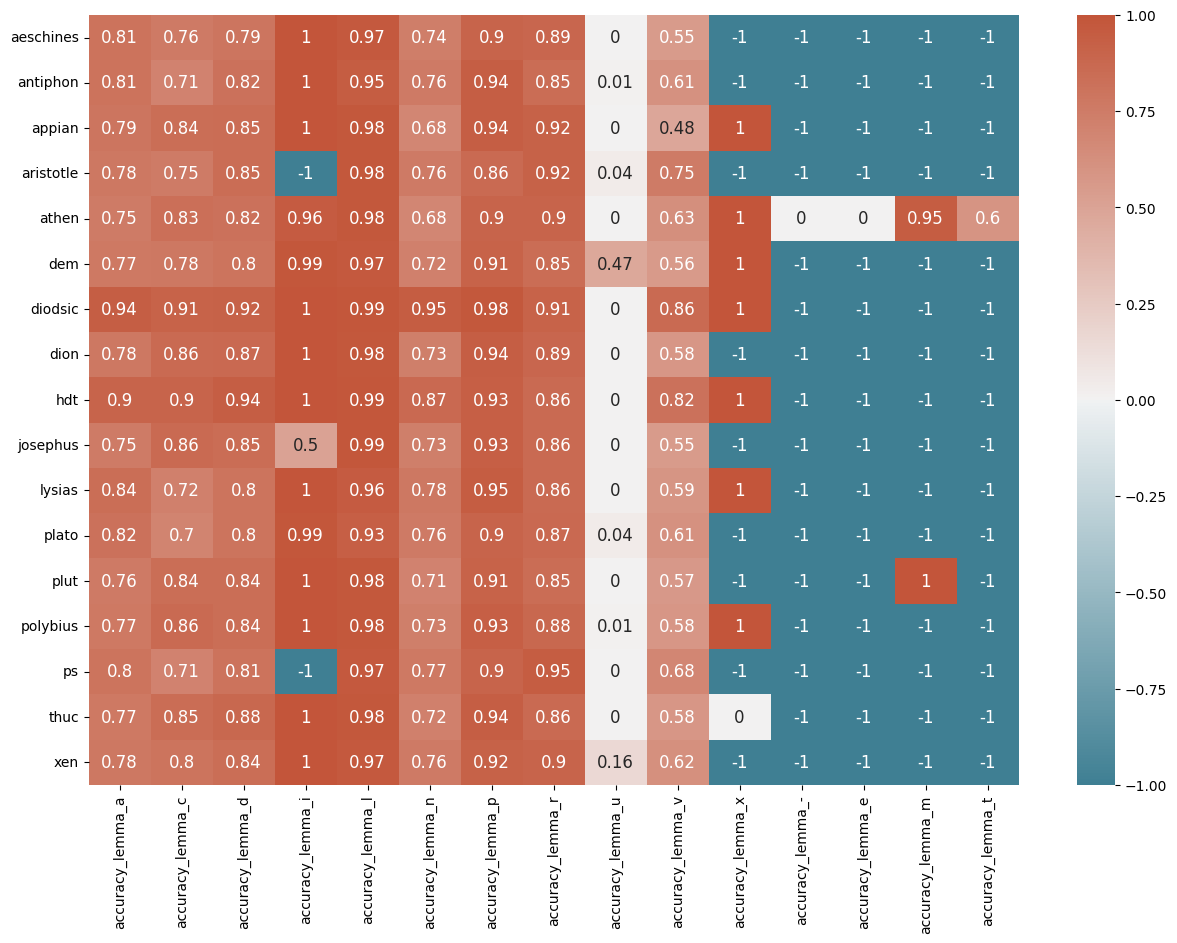

In [44]:
sub_cols = [ 'accuracy_lemma_a', 'accuracy_lemma_c',
       'accuracy_lemma_d', 'accuracy_lemma_i', 'accuracy_lemma_l',
       'accuracy_lemma_n', 'accuracy_lemma_p', 'accuracy_lemma_r',
       'accuracy_lemma_u', 'accuracy_lemma_v', 'accuracy_lemma_x',
       'accuracy_lemma_-', 'accuracy_lemma_e', 'accuracy_lemma_m',
       'accuracy_lemma_t']
sub_df = accuracy_lemma_by_pos[sub_cols]
sub_df = sub_df.fillna(-1)
cmap = sns.diverging_palette(220, 20, as_cmap = True)
plt.figure(figsize = (15,10))
sns.heatmap(sub_df, cmap=cmap, center=0, annot=sub_df, fmt='g',
                xticklabels=sub_cols, yticklabels=author_list,
                annot_kws={'size': 12})
plt.show()
#ROSSO SCURO 1 AZZECCATO DI PIU, BIANCO 0 NON LI HA AZZECCATI. -1 INDICA NAN QUINDI VUOL DIRE CHE NEL GOLD STANDARD NON C'ERA T ES. 

matrici di confusione

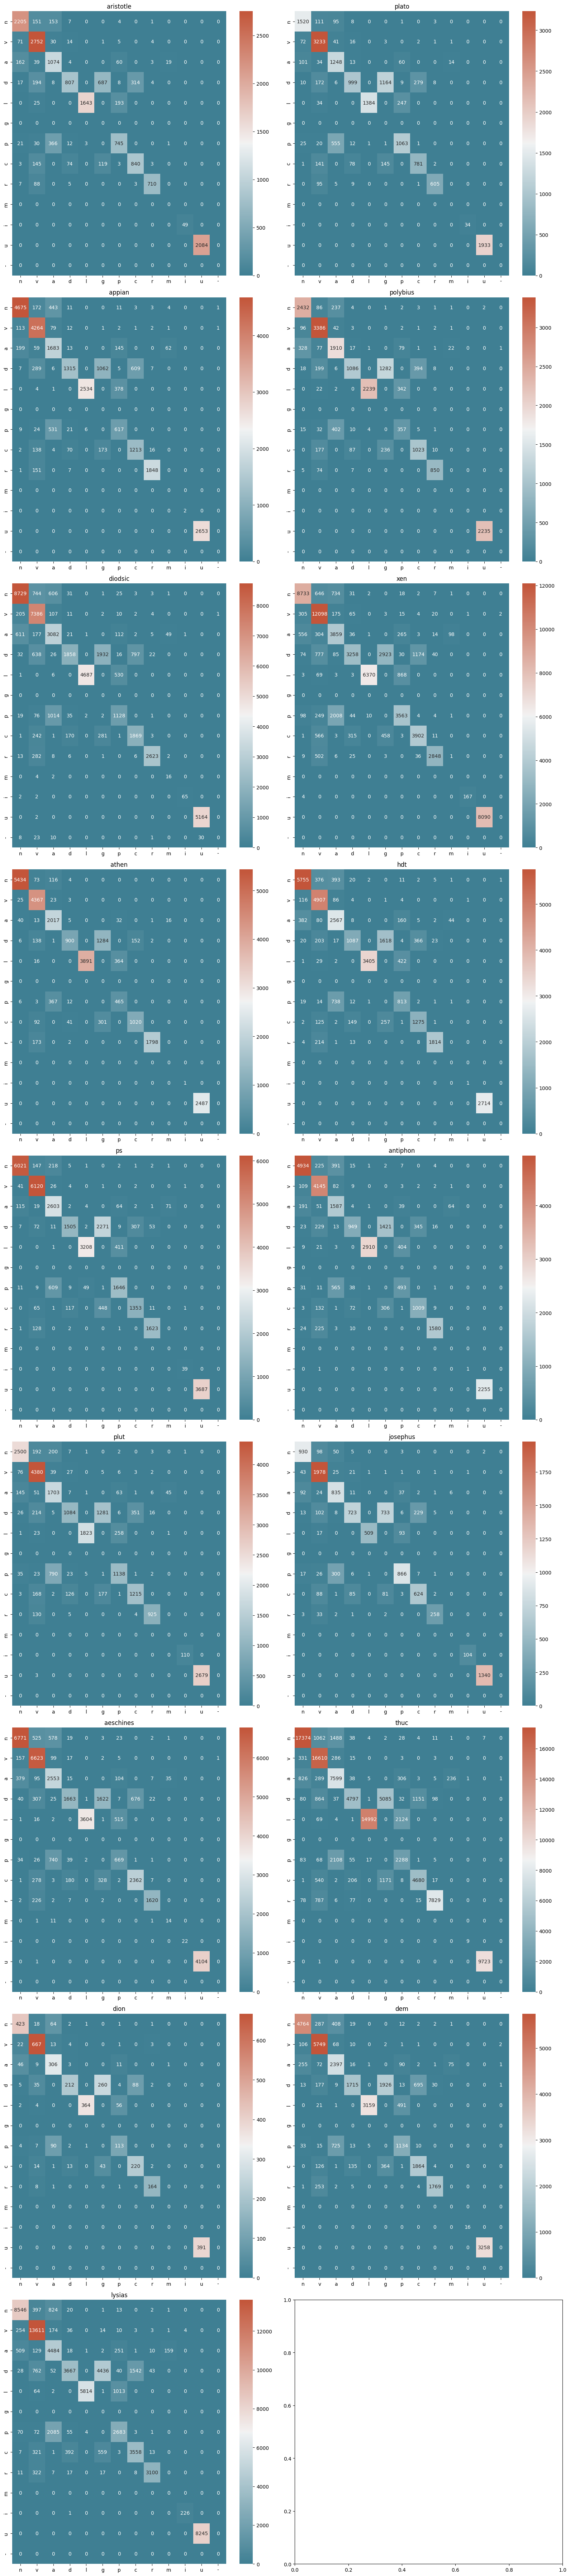

In [45]:
# Assuming 'author_dic', 'author_udpipe', and 'author_true' are defined
author_keys = list(author_dic.keys())
num_plots = len(author_keys)

# Define labels
lab_prima_posizione = 'n v a d l g p c r m i u -'.split(' ')

# Determine grid size (e.g., 3 columns, rows computed accordingly)
cols = 2
rows = math.ceil(num_plots / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*8, rows*8))

cmap = sns.diverging_palette(220, 20, as_cmap=True)

for i, key in enumerate(author_keys):
    predictions = author_udpipe[i][['FORM', 'LEMMA', 'XPOS']].to_dict('records')
    gold_data = author_true[i][['@form', '@lemma', '@postag']].to_dict('records')

    pred_list = []
    gold_list = []
    for pred, gold in zip(predictions, gold_data):
        gold_pos = str(gold['@postag'])
        pred_pos = str(pred['XPOS'])
        # Extract only the first character
        pred_list.append(pred_pos[0])
        gold_list.append(gold_pos[0])

    # Compute confusion matrix
    cm = confusion_matrix(gold_list, pred_list, labels=lab_prima_posizione)

    # Determine the subplot location
    row = i // cols
    col = i % cols

    # If you have a single row, axes might not be 2D
    ax = axes[row, col] if rows > 1 else axes[col]

    # Plot the heatmap on the given axis
    
    sns.heatmap(cm, cmap=cmap, annot=cm, fmt='d',
                xticklabels=lab_prima_posizione, yticklabels=lab_prima_posizione,
                annot_kws={'size': 10}, ax=ax)
    ax.set_title(key)

# Adjust layout for clarity
plt.tight_layout()
plt.show()

In [ ]:
''''
sulla diagonale troviamo i valori classificati correttamente. es. 2205 n è stato classificato come n 
sommando ciascuna riga ottengo il  numero di una classe all'interno del totale delle label. esempo 2205 + 151 + 153 è il numero di 
n in gold_list. Es. di tutti gli n, 2205 sono classificati come n, 151 come v e 153 come a, 7 come d etc...
Sommando le colonne trovi il totale di una classe all'interno delle predizioni (pred_list).Es. 2205 + 71 + 162 + 17 etc... è il totale di n che 
trovi nell'array delle predizioni 
Es 2205 sono n classificati come n, 71 v class come n, 162 sono a classificati come n, 17 sono d classificati come n)
'''